In [1]:
import common

/Users/petergedeck/git/Mistat-bootstrap-analysis/.venv/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [3]:
import random

random.seed(123)
np.random.seed(123)

In [4]:
# s, v0, k, t0
data = common.preparePistonDataset()
data

,milliseconds,group,x1,x2,x3,x4
0,60.226485,1,-1.0,-1.0,-1.0,-1.0
1,65.020360,1,-1.0,-1.0,-1.0,-1.0
2,57.302374,1,-1.0,-1.0,-1.0,-1.0
3,50.978262,1,-1.0,-1.0,-1.0,-1.0
4,56.526159,1,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...
155,68.963006,32,0.0,0.0,0.0,0.0
156,51.328098,32,0.0,0.0,0.0,0.0
157,51.372896,32,0.0,0.0,0.0,0.0
158,59.049678,32,0.0,0.0,0.0,0.0


In [5]:
main_terms = 'x1 + x2 + x3 + x4'
main_terms_significant = 'x1 + x2 + x3'
interaction_terms = 'x1:x2 + x1:x3 + x2:x3'
quadratic_terms = 'I(x1 ** 2) + I(x2 ** 2) + I(x3 ** 2)'
formula_main = f'milliseconds ~ {main_terms}'
formula_interaction = f'milliseconds ~ {main_terms_significant} + {interaction_terms}'
formula_quadratic = f'milliseconds ~ {main_terms_significant} + {quadratic_terms}'
formula_full = f'milliseconds ~ {main_terms_significant} + {interaction_terms} + {quadratic_terms}'
group = ['x1', 'x2', 'x3', 'x4']

In [6]:
results = {
    'ols_main': common.buildModel(data, formula_main),
    'ols_interaction': common.buildModel(data, formula_interaction),
    'ols_quadratic': common.buildModel(data, formula_quadratic),
    'ols_full': common.buildModel(data, formula_full),
}
results['ols_main'].summary().tables[1]


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,63.6518,0.823,77.302,0.000,62.025,65.278
x1,-15.5256,0.951,-16.329,0.000,-17.404,-13.647
x2,13.0152,0.951,13.689,0.000,11.137,14.893
x3,4.7356,0.951,4.981,0.000,2.857,6.614
x4,0.3212,0.951,0.338,0.736,-1.557,2.199


In [7]:
results['ols_full'].summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,60.3069,1.197,50.397,0.000,57.942,62.671
x1,-15.5256,0.788,-19.709,0.000,-17.082,-13.969
x2,13.0152,0.788,16.523,0.000,11.459,14.572
x3,4.7356,0.788,6.012,0.000,3.179,6.292
x1:x2,-4.9101,0.965,-5.089,0.000,-6.816,-3.004
x1:x3,-2.2820,0.965,-2.365,0.019,-4.188,-0.376
x2:x3,1.6966,0.965,1.759,0.081,-0.210,3.603
I(x1 ** 2),4.5094,0.708,6.370,0.000,3.111,5.908
I(x2 ** 2),0.2682,0.708,0.379,0.705,-1.131,1.667
I(x3 ** 2),-0.3178,0.708,-0.449,0.654,-1.717,1.081


In [8]:
# How often does bootstrap analysis remove whole groups
from collections import Counter
ngroups = len(set(data['group']))
missing = []
for _ in range(10_000):
    missing.append(ngroups - len(set(data.sample(frac=1, replace=True)['group'])))
(np.array([Counter(missing).get(n, 0) for n in range(5)]) / len(missing)).round(3)

array([0.814, 0.172, 0.013, 0.001, 0.   ])

# Bootstrap analysis

In [9]:
methods = {
    'BA': (common.bootstrapAnalysis, False),
    'BBA': (common.befittingBootstrapAnalysis, True),
    'pBBA': (common.parametricBefittingBootstrapAnalysis, True),
    'pBA': (common.parametricBootstrapAnalysis, False),
    'wBA': (common.wildBootstrapAnalysis, False),
}

def compareMethods(results, nrepeats):
    for key, (method, require_group) in methods.items():
        kwargs = {'nrepeats': nrepeats}
        if require_group:
            kwargs['group'] = group
        results.update({
            f'{key}_main': method(data, formula_main, **kwargs),
            f'{key}_interaction': method(data, formula_interaction, **kwargs),
            f'{key}_quadratic': method(data, formula_quadratic, **kwargs),
            f'{key}_full': method(data, formula_full, **kwargs),
        })
    return results

results = compareMethods(results, 5_000)


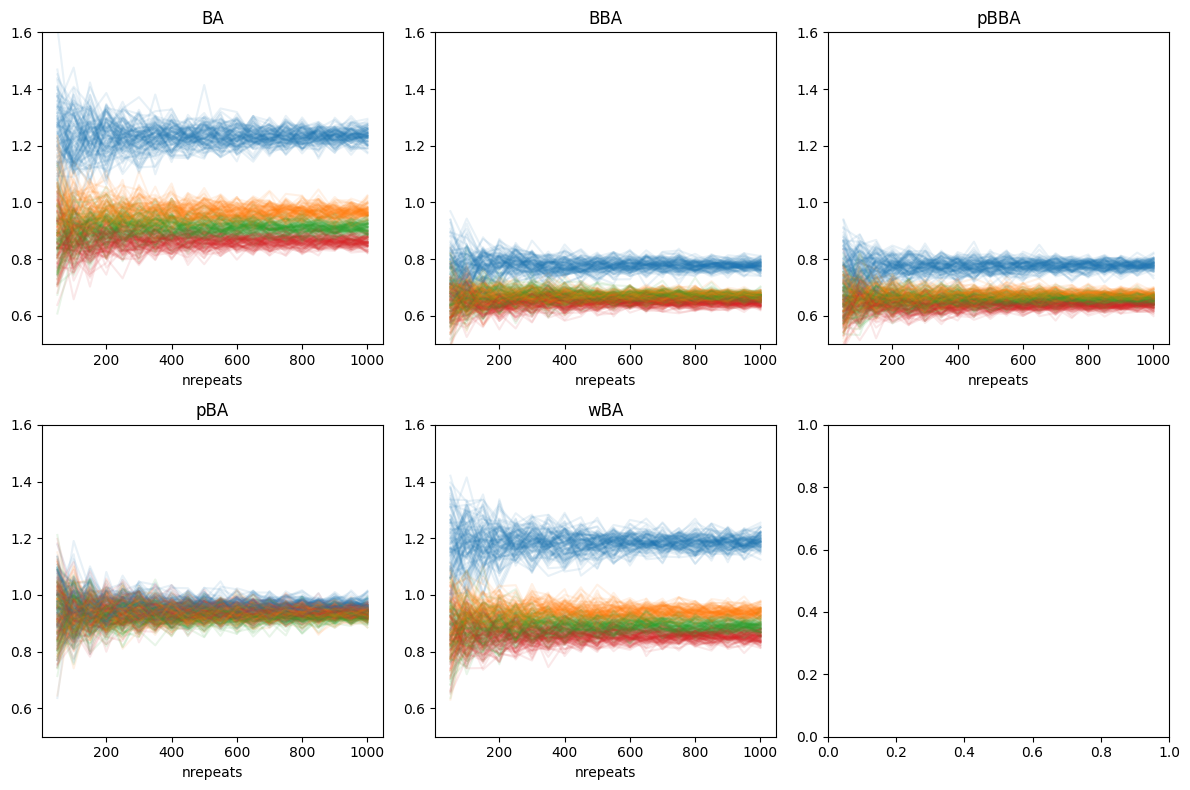

In [10]:
experiment = 'full'
terms = formula_full.split(' ~ ')[1].split(' + ')
experiment = 'main'
terms = formula_main.split(' ~ ')[1].split(' + ')
colors = [f'C{i}' for i in range(len(terms))]
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
for ax, method in zip(np.array(axes).flatten(), methods):
    for n in range(100):
        std_coef = []
        for i in range(50, 1050, 50):
            std_coef.append({'nrepeats': i, 'sample': n, **results[f'{method}_{experiment}'].sample(i).std().to_dict()})
        ax = pd.DataFrame(std_coef).plot(x='nrepeats', y=terms, title=method, ax=ax, alpha=0.1, color=colors)
    ax.get_legend().remove()
    ax.set_ylim(0.5, 1.6)
    # ax.set_ylim(0.3, 1.4)
plt.tight_layout()
plt.show()

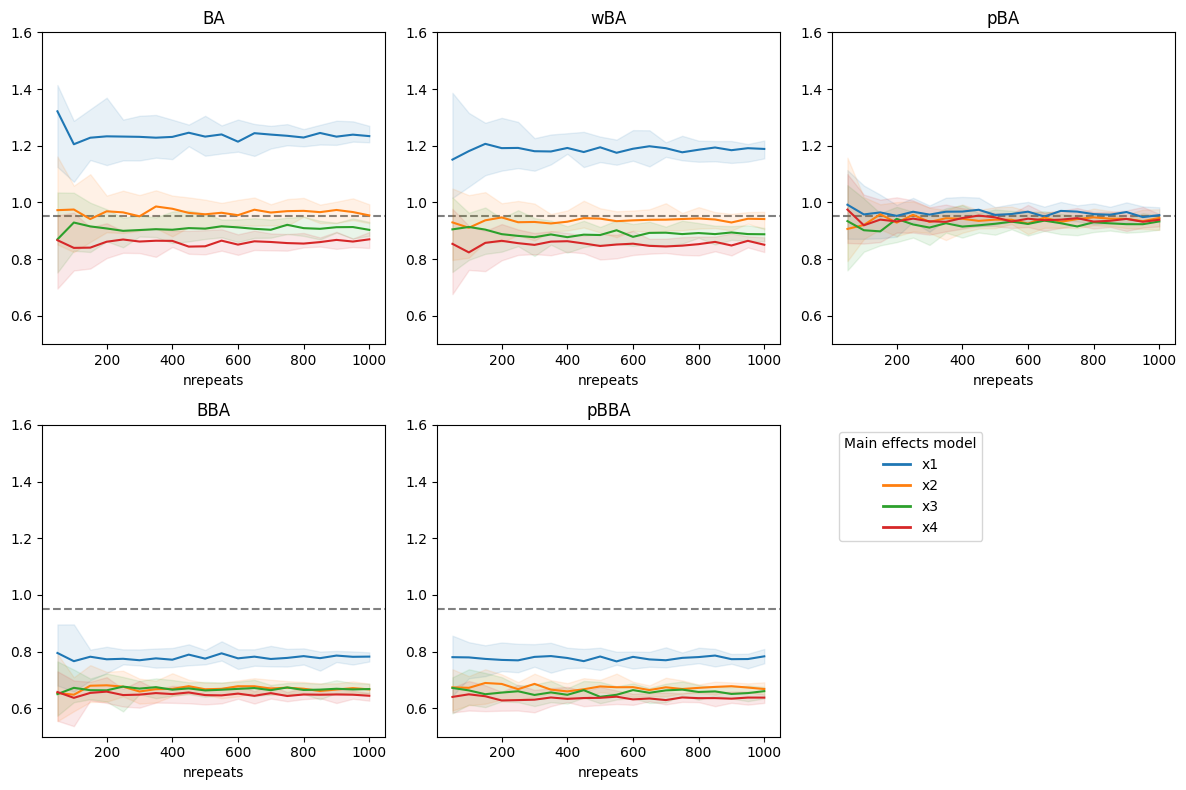

In [23]:
def graph_std_coef(results, experiment, formula, ylim, *, 
                   ols_model=None,
                   max_bootstrap_size=1000, resamples=100, ci_bands=True, filename=None, seed=123):
    random.seed(seed)
    np.random.seed(seed)
    title = {'main': 'Main effects model', 'full': 'Model with interactions and quadratic terms'}
    terms = formula.split(' ~ ')[1].split(' + ')
    # terms.insert(0, 'Intercept')
    colors = [f'C{i}' for i in range(len(terms))]

    _, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
    axes = np.array(axes).flatten()
    for ax, method in zip(axes, ['BA', 'wBA', 'pBA', 'BBA', 'pBBA']):
            
        if ci_bands:
            median = []
            q_5 = []
            q95 = []
            for i in range(50, max_bootstrap_size + 1, 50):
                x = []
                for n in range(resamples):
                    x.append({'nrepeats': i, 'sample': n, **results[f'{method}_{experiment}'].sample(i).std().to_dict()})
                median.append(pd.DataFrame(x).quantile(0.5).to_dict())
                q_5.append(pd.DataFrame(x).quantile(0.05).to_dict())
                q95.append(pd.DataFrame(x).quantile(0.95).to_dict())
            ax = pd.DataFrame(median).plot(x='nrepeats', y=terms, title=method, ax=ax, color=colors)
            for col, term in zip(colors, terms):
                ax.fill_between(pd.DataFrame(median)['nrepeats'], pd.DataFrame(q_5)[term], pd.DataFrame(q95)[term], alpha=0.1, color=col)
        else:
            for n in range(resamples):
                std_coef = []
                for i in range(50, 1050, 50):
                    std_coef.append({'nrepeats': i, 'sample': n, **results[f'{method}_{experiment}'].sample(i).std().to_dict()})
                ax = pd.DataFrame(std_coef).plot(x='nrepeats', y=terms, title=method, ax=ax, alpha=0.5, color=colors)
        if ols_model:
            bse = results[ols_model].bse
            ax.axhline(bse['x1'], color='grey', zorder=-1, ls='--')
            if 'x1:x2' in bse:
                ax.axhline(bse['x1:x2'], color='grey', zorder=-1, ls='--')
            if 'I(x1 ** 2)' in bse:
                ax.axhline(bse['I(x1 ** 2)'], color='grey', zorder=-1, ls='--')

        ax.get_legend().remove()
        ax.set_ylim(*ylim)
    legend_elements = [Line2D([0], [0], color=col, ls='-',lw=2, label=term) for term, col in zip(terms, colors)]
    axes[-1].legend(handles=legend_elements, loc='upper left', title=title[experiment])
    axes[-1].axis('off')
    plt.tight_layout()
    common.saveFigure(filename)

# graph_std_coef(results, 'main', formula_main, (0.5, 1.6), resamples=20, ci_bands=False, filename='S_piston-std-main-20-resamples.pdf')
graph_std_coef(results, 'main', formula_main, (0.5, 1.6), ols_model='ols_main', resamples=20, ci_bands=True, filename='S_piston-std-main-20-bands.pdf')
# graph_std_coef(results, 'main', formula_main, (0.5, 1.6), ols_model='ols_main', resamples=300, ci_bands=True, filename='S_piston-std-main-300-bands.pdf')


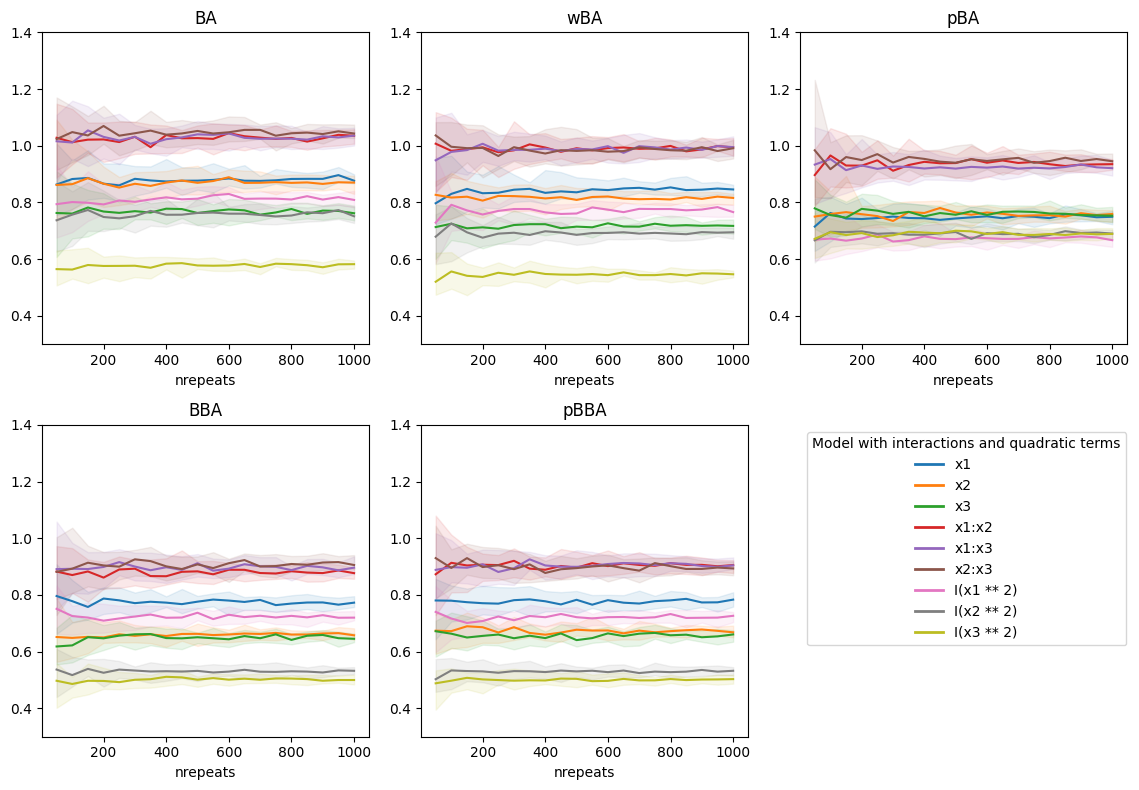

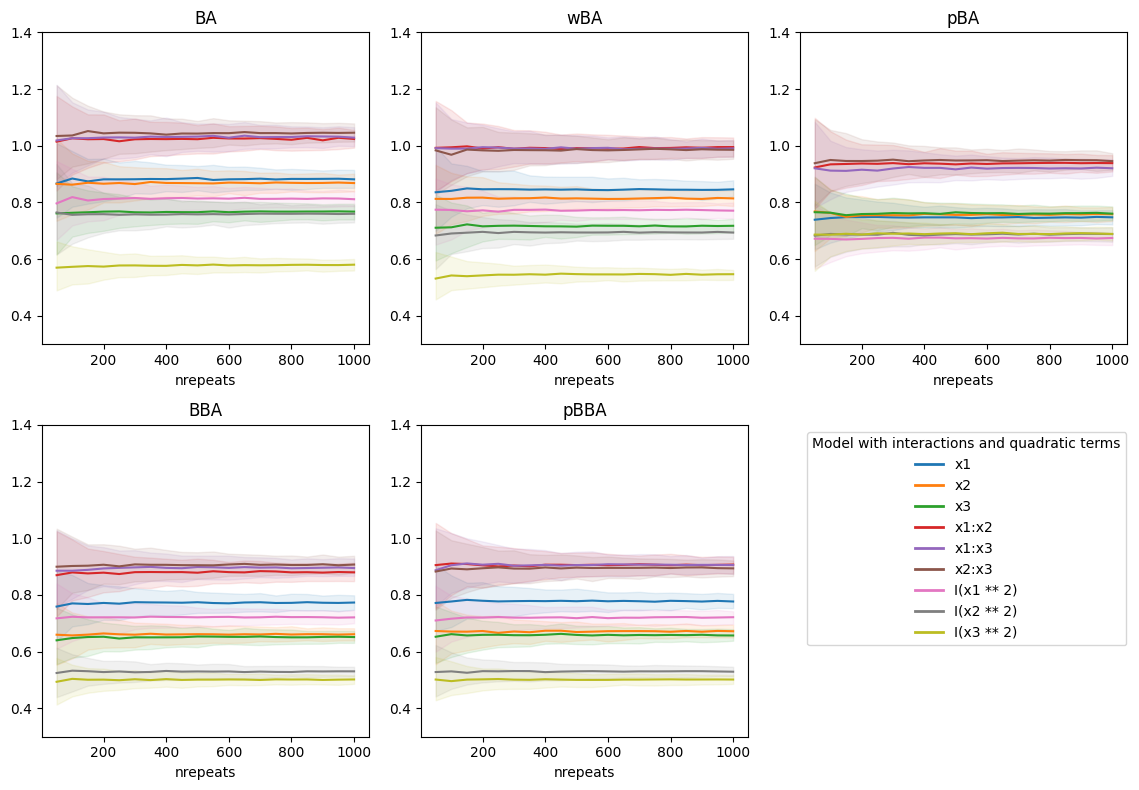

In [13]:
graph_std_coef(results, 'full', formula_full, (0.3, 1.4), ols_model='ols_full', resamples=20, ci_bands=True, filename='S_piston-std-full-20-bands.pdf')
graph_std_coef(results, 'full', formula_full, (0.3, 1.4), ols_model='ols_full', resamples=300, ci_bands=True, filename='S_piston-std-full-300-bands.pdf')